In [22]:
!pip install pandas
!pip install numpy
!pip install boto3
!pip install dspy-ai
!pip install scikit-learn
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 k

In [36]:
import pandas as pd
train_df = pd.read_csv('./data/train.tsv', sep='\t')
print(len(train_df))

68


In [37]:
import dspy
from typing_extensions import Literal

class Classify(dspy.Signature):
    """Classify a text into one of the given options"""

    text = dspy.InputField()
        
    answer: Literal['Billing Inquiries','Policy Administration','Claims Assistance','Coverage Explanations','Quotes and Proposals','Account Management','Billing Disputes','Claims Disputes','Policy Comparisons','General Inquiries'] = dspy.OutputField(desc="Only one word. From the given list")

In [38]:
from dspy.functional import TypedChainOfThought
class GetLabel(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_label = dspy.TypedChainOfThought(Classify)
    
    def forward(
            self,
            text
    ):
        label = self.generate_label(text = text)
        
        return label

In [39]:
# Create a dataset
dataset = []
for i, row in train_df.iterrows():
    example = dspy.Example(text = row['text'], answer=row['label'])
    dataset.append(example.with_inputs('text'))


labels = list(set(train_df['label'].unique()))

In [40]:
import dspy
import random

# Does backoff by 3, 9, 27, 60 seconds.
def exponential_backoff(attempts):
    return min(3**attempts, 60)

bedrock_claude = dspy.AWSAnthropic(
    aws_provider = dspy.Bedrock(region_name="us-east-1", profile_name="stage"),
    model="anthropic.claude-3-5-sonnet-20240620-v1:0",
)
dspy.settings.configure(backoff_time=exponential_backoff)
dspy.settings.configure(lm=bedrock_claude)

100%|██████████| 68/68 [04:31<00:00,  4.00s/it]
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wckd/Desktop/dspy/DSPyClassification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Classification report
                       precision    recall  f1-score   support

   Account Management       1.00      0.83      0.91         6
     Billing Disputes       0.78      0.78      0.78         9
    Billing Inquiries       0.57      0.67      0.62         6
    Claims Assistance       0.75      1.00      0.86         6
      Claims Disputes       1.00      0.75      0.86         8
Coverage Explanations       0.40      1.00      0.57         8
    General Inquiries       0.00      0.00      0.00         9
Policy Administration       1.00      0.83      0.91         6
   Policy Comparisons       1.00      1.00      1.00         5
 Quotes and Proposals       1.00      0.60      0.75         5

             accuracy                           0.72        68
            macro avg       0.75      0.75      0.72        68
         weighted avg       0.71      0.72      0.69        68

Confusion Matrix


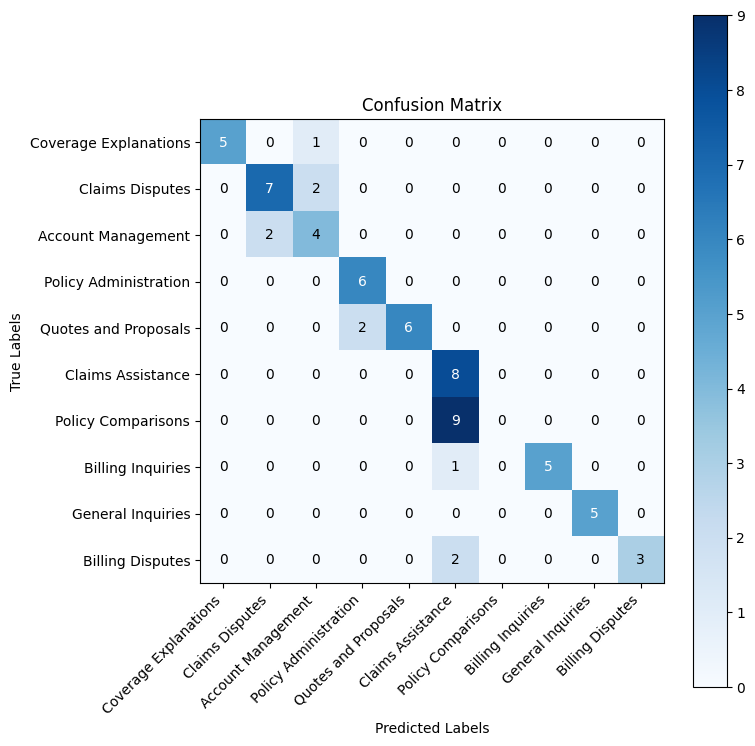

In [41]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


classifier = GetLabel()

llm_preds = []
true_labels = []
for data_point in tqdm(dataset, total=len(dataset)):
    llm_preds.append(
        classifier(**data_point.inputs()).answer
    )
    true_labels.append(data_point.answer)

print("Classification report")
print(classification_report(true_labels, llm_preds))
print("Confusion Matrix")
cm = confusion_matrix(true_labels, llm_preds)
plot_confusion_matrix(cm,labels)